In [1]:
from math import log, exp

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from scipy.stats import (norm, lognorm, 
                         gamma, percentileofscore)

import seaborn as sns

# Section

- Free
- Full control - not a black box
- fully customizable
- easy export of results (images/Excel

## Subsection

lorem ipsum

[SciPy's](https://www.scipy.org) [*statistical submodule*](https://docs.scipy.org/doc/scipy/reference/stats.html)
[*norm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), 
[*lognorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html), 
[*beta*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html), 
[*triang*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html), &
[*truncnorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html) continous distributions.

random variates method [*rvs( )*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html)

[*clip( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) method
[*describe( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe) method

# Using SciPy to generate random variates from a distribution

`distribution = norm(loc=1, scale=2)`

`distribution.rvs(n)`

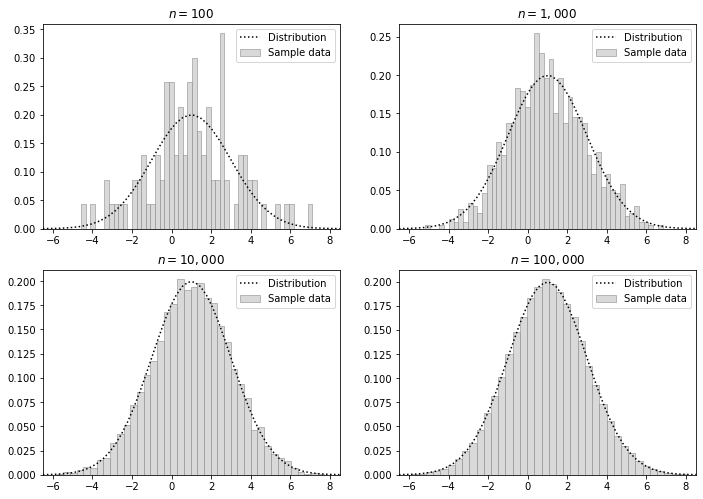

In [14]:
# define distribution
distribution = norm(loc=1, scale=2)

# generate x y data for the ideal distribution
x = np.linspace(-6.5, 8.5)
y = distribution.pdf(x)

# create Pyplot axes for plotting results
fig, ax = plt.subplots(2, 2, figsize=(11.7, 8.3))
ax = ax.flatten()

for i, n in enumerate(np.logspace(2, 5, num=4, base=10)):
    # plot a histogram of the random variates
    ax[i].hist(distribution.rvs(int(n)), bins=50, density=True,
               fc='0.85', ec='0.5', lw=0.5,
               label='Sample data')
    
    # plot ideal distribution
    ax[i].plot(x, y, c='k', ls=':', 
               label='Distribution')
    
    # format the axes
    ax[i].set_title("$n={:,.0f}$".format(n))
    ax[i].set_xlim(-6.5, 8.5)
    ax[i].legend()
plt.show()



In [36]:
%%timeit 
# distribution.rvs(int(1_000_000_000))

28.8 s ± 443 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To make things a little simpler going forward, we can create some functions to instantiate SciPy distribution objects using more user firendly parameters, especially for the log-normal distribution. The two functions below do this taking the *P<sub>90</sub>* and *P<sub>10</sub>* as input parameters.

In [16]:
def norm_dist(P90, P10):
    mean = (P90+P10)/2 
    std = (P10-P90)/(norm.ppf(0.9)-norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    

def lognorm_dist(P90, P10):
    std = log(P10 / P90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(P10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))

# Generating random variates for volumetric parameters

We can now 

In [34]:
params = {
    'GRV':      lognorm_dist(P90=10_000_000, P10=25_000_000),
    'NTG':      norm_dist(P90=0.6, P10=0.8),
    'Porosity': norm_dist(P90=0.125, P10=0.225),
    'Sw':       norm_dist(P90=0.15, P10=0.45),
    'FVF':      norm_dist(P90=1.1, P10=1.3),
    'RF':       norm_dist(P90=0.15, P10=0.25),
}
realisations = pd.DataFrame([], columns=params)

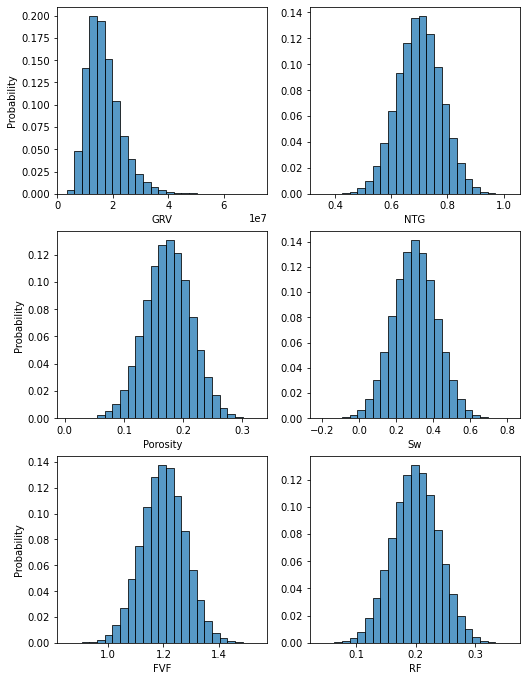

In [35]:
num_samples = 100_000

fig, ax = plt.subplots(nrows=(len(params) // 2 
                              + len(params) % 2),
                       ncols=2,
                       figsize=(8.3, 11.7))
ax = ax.flatten()

for i, (parameter, distr) in enumerate(params.items()):
    x = distr.rvs(num_samples)
    realisations[parameter] = x
    sns.histplot(data=realisations, x=parameter, ax=ax[i], 
                 stat='probability', bins=25,)
    if i % 2 == 1:
        ax[i].set_ylabel(None)
plt.show()

In [145]:
realisations.describe(percentiles=[0.1, 0.5, 0.9],)

,GRV,NTG,Porosity,Sw,FVF,RF
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684260e+07,0.699789,0.174951,0.299882,1.200215,0.200197
std,6.192946e+06,0.078203,0.039105,0.117051,0.078099,0.039098
min,3.256557e+06,0.397423,0.002715,-0.220603,0.857529,0.037467
10%,1.001951e+07,0.599775,0.124940,0.149493,1.099900,0.150047
50%,1.580189e+07,0.700095,0.174980,0.300122,1.200105,0.200205
90%,2.499464e+07,0.799667,0.225175,0.449558,1.300215,0.250235
max,6.435416e+07,1.032028,0.330939,0.790745,1.546863,0.381602


In [146]:
realisations.Porosity = realisations.Porosity.clip(lower=0.1)
realisations.Sw = realisations.Sw.clip(lower=0.15, upper=0.70)

# Volumetric calculaions and reporting

In [147]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

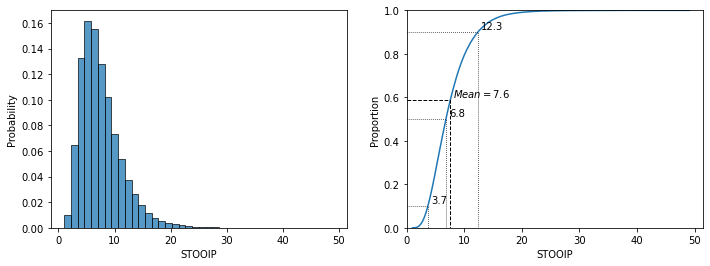

In [148]:
fig, ax = plt.subplots(ncols=2, figsize=(11.7,4))
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)
sns.ecdfplot(realisations.STOOIP, ax=ax[1])
ax[1].set_xlim(left=0)
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[1].plot([0] + [q] * 2,
               [p] * 2 + [0],
               c='k', ls=":", lw=0.75)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels')
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(
    realisations.STOOIP,
    mean,
    kind='weak')/100
ax[1].plot([0] + [mean] * 2,
               [Pmean] * 2 + [0],
               c='k', ls="--", lw=1)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels')
plt.show()

In [150]:
def formatter(s):
    formats = {
        'Sw':       '{:.1%}',
        'Porosity': '{:.1%}',
        'FVF':      '{:.2}',
        'RF':       '{:.1%}',
        'GRV':      '{:,.2g}',
        'STOOIP':   '{:,.1f}',
        'Resource':  '{:,.1f}',
        'NTG':      '{:.1%}',
    }
    return(s.apply(formats[s.name].format))

def borders(s):
    fmt = 'border-top: 1px solid black; ' \
          + 'font-weight: bold'
    return [fmt for e in s]

summary = realisations.describe(percentiles=[0.1, 0.5, 0.9],) \
    .apply(formatter).T \
    .iloc[:,[3,4,5,6,7,1]]
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']
summary.style.apply(borders, axis=1, 
                    subset=pd.IndexSlice[['STOOIP', 'Resource'], :])

,Min,P90,P50,P10,Max,Mean
GRV,3.3e+06,1e+07,1.6e+07,2.5e+07,6.4e+07,1.7e+07
NTG,39.7%,60.0%,70.0%,80.0%,103.2%,70.0%
Porosity,10.0%,12.5%,17.5%,22.5%,33.1%,17.5%
Sw,15.0%,15.0%,30.0%,45.0%,70.0%,30.5%
FVF,0.86,1.1,1.2,1.3,1.5,1.2
RF,3.7%,15.0%,20.0%,25.0%,38.2%,20.0%
STOOIP,1.0,3.7,6.8,12.3,49.1,7.6
Resource,0.1,0.7,1.3,2.6,12.7,1.5


In [90]:
from IPython.display import Javascript
import urllib.parse

Javascript("const code = Jupyter.notebook.get_cell(1).get_text(); IPython.notebook.kernel.execute(`myvar = '${encodeURI(code)}'`);")
urllib.parse.unquote(myvar)

'# Section\n\n## Subsection\n\nlorem ipsum'

In [88]:
myvar

'#%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum'

In [92]:
import markdown

In [93]:
html = markdown.markdown(myvar)

In [94]:
html

'<h1>%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum</h1>'

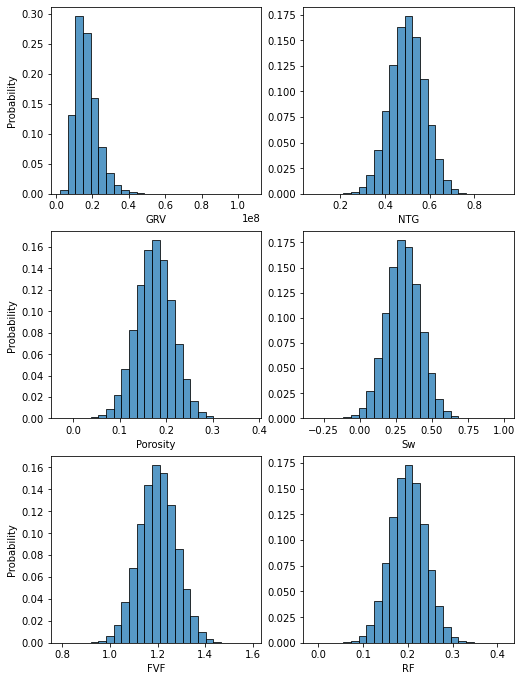

In [64]:
num_samples = 20_000_000

fig, ax = plt.subplots(nrows=(len(params) // 2 
                              + len(params) % 2),
                       ncols=2,
                       figsize=(8.3, 11.7))
ax = ax.flatten()
realisations = pd.DataFrame([], columns=params)

for i, (k, v) in enumerate(params.items()):
    x = v.rvs(num_samples)
    realisations[k] = x
    sns.histplot(data=realisations, x=k, ax=ax[i], 
                 stat='probability', bins=25,)
    if i % 2 == 1:
        ax[i].set_ylabel(None)
plt.show()

In [65]:
realisations.Porosity = realisations.Porosity.clip(lower=0.1)
realisations.Sw = realisations.Sw.clip(lower=0.15)
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

In [115]:
summary_stats = realisations.Resource.groupby(by=np.arange(200). \
                                repeat(100_000)). \
                                quantile([0.1, 0.5, 0.9]). \
                                unstack()
summary_stats['Mean'] = realisations.Resource.groupby(by=np.arange(200). \
                                repeat(100_000)). \
                                mean()
summary_stats = summary_stats / summary_stats.mean()

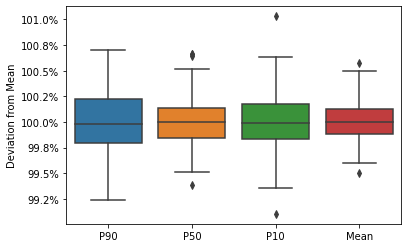

In [116]:
fig, ax = plt.subplots()
summary_stats.columns = ['P90', 'P50', 'P10', 'Mean']
sns.boxplot(data=summary_stats.melt(value_name='Deviation from Mean'), 
            x='variable', 
            y='Deviation from Mean', 
            ax=ax)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
ax.set_xlabel(None)
plt.show()